In [19]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from numpy.linalg import eigh, svd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# News labels
twenty_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [32]:
docs, labels = fetch_20newsgroups(
    subset='all',
    shuffle=True, 
    return_X_y=True
)

In [33]:
len(docs)

18846

In [30]:
print(labels[0])
print(docs[0])

7
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [31]:
len(docs)

11314

In [5]:
count_vect = CountVectorizer(stop_words='english')
tfidf_transformer = TfidfTransformer()

# X_train_counts = count_vect.fit_transform(train_sample)
features_counts = count_vect.fit_transform(docs[:3000])
features_tfidf = tfidf_transformer.fit_transform(features_counts)
features_tfidf.shape

(3000, 61689)

In [6]:
corpus = features_tfidf.toarray()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    corpus, labels[:3000],
    test_size=0.25, random_state=42
)

### SVD decomposition for feature selection

In [11]:
U, s, Vt = svd(X_train, full_matrices=False)
print('U shape =', np.shape(U), 's length =', len(s), 'Vt shape =', np.shape(Vt))

U shape = (2250, 2250) s length = 2250 Vt shape = (2250, 61689)


In [10]:
def coord_reduction(train, test, n, svd):
    """
    Calculate PC over train data and give the test data with n components
    """
    train_red = svd[0][:,0:n] * svd[1][0:n]
    test_red = np.dot(test, svd[2][0:n,:].transpose())
    
    return train_red, test_red

In [38]:
# Classification
results = []

for n_comp in range(1, 2001, 10):
    X_train_red, X_test_red = coord_reduction(X_train, X_test, n_comp, (U, s, Vt))
    model = KNeighborsClassifier(n_neighbors=1, p=2)
    model.fit(X_train_red, y_train)
    results.append(
        (
            n_comp,
            accuracy_score(
                y_test, model.predict(X_test_red), normalize=True)*100
        )
    )

Text(0, 0.5, 'Accuracy')

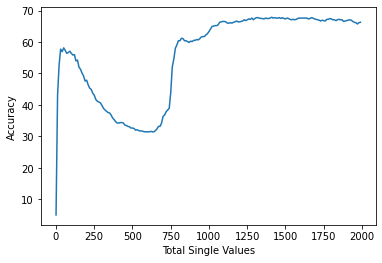

In [39]:
components = [result[0] for result in results]
acc = [result[1] for result in results]

plt.plot(components, acc)
plt.xlabel('Total Single Values')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accumulated Variability')

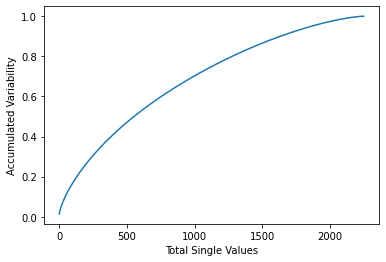

In [28]:
total_var = np.sum(s**2)
y_plot = np.cumsum(s**2) / total_var
x_plot = np.array(range(len(s)))

plt.plot(x_plot, y_plot)
plt.xlabel('Total Single Values')
plt.ylabel('Accumulated Variability')